# Modelli Diffusivi
Diffusion Models from Scracth

In [1]:
from keras.datasets import mnist
import numpy as np
import tensorflow as tf

2023-09-28 18:08:12.480921: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 18:08:12.630645: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 18:08:12.632426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 18:08:14.893640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [59]:
"""
# Standardizzazione
mean = np.mean(x_train)
sigma = np.std(x_train)

x_train = ((x_train - mean) / sigma).astype(np.float32)
x_test = ((x_test - mean) / sigma).astype(np.float32)
"""

'\n# Standardizzazione\nmean = np.mean(x_train)\nsigma = np.std(x_train)\n\nx_train = ((x_train - mean) / sigma).astype(np.float32)\nx_test = ((x_test - mean) / sigma).astype(np.float32)\n'

In [3]:
# Normaliz.
x_train = (x_train / 255.).astype(np.float32) # 255. perché siamo in grayscale, i valori vanno da 0-255
x_test = (x_test / 255.).astype(np.float32)

x_train = np.pad(x_train, pad_width=((0, 0), (2, 2), (2, 2)))

**Note**
+ Standardizzazione: trasformare una variabile calcolandone dei valori "standard", per confronto più efficace con altre variabili
+ Normalizzazione: rendere la distrib. di una var. più simile a quella della distrib. Normale
[Link](https://paolapozzolo.it/variabile-standardizzata-una-guida-pratica/#:~:text=standardizzare%20significa%2C%20come%20abbiamo%20gi%C3%A0,a%20quella%20della%20distribuzione%20Normale.)

In [136]:
# Test per capire cosa se la normalizzazione funziona (2 modi equivalenti)
np.unique(x_train / 255.) # non in-place; sarebbe da fare prima della Normaliz.
np.max(x_train), np.min(x_train)

(1.0, 0.0)

## Copia del modello di "segmentazione" del notebook Lezione6

In [4]:
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose

In [5]:
# fully convolutional neural network (UNET)

fcnn = Sequential(
    [
        Conv2D(filters=64, kernel_size=3, padding="same", strides=2, activation="relu"),
        Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
        Conv2D(filters=128, kernel_size=3, padding="same", strides=2, activation="relu"),
        Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
        Conv2D(filters=256, kernel_size=3, padding="same", strides=2, activation="relu"),
        Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),

        Conv2DTranspose(filters=256, kernel_size=3, padding="same", activation="relu"),
        Conv2DTranspose(filters=256, kernel_size=3, padding="same", strides=2, activation="relu"),
        Conv2DTranspose(filters=128, kernel_size=3, padding="same", activation="relu"),
        Conv2DTranspose(filters=128, kernel_size=3, padding="same", strides=2, activation="relu"),
        Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation="relu"),
        Conv2DTranspose(filters=64, kernel_size=3, padding="same", strides=2, activation="relu"),

        Conv2D(filters=1, kernel_size=3, padding="same")
    ]
)

Note sull'architettura FullyConv.
https://www.andreaprovino.it/fcn e https://www.redhotcyber.com/rubriche/alla-scoperta-dellintelligenza-artificiale/

In [6]:
fcnn.build(input_shape=[32, 32, 32, 1])

In [7]:
fcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 16, 16, 64)          640       
                                                                 
 conv2d_1 (Conv2D)           (32, 16, 16, 64)          36928     
                                                                 
 conv2d_2 (Conv2D)           (32, 8, 8, 128)           73856     
                                                                 
 conv2d_3 (Conv2D)           (32, 8, 8, 128)           147584    
                                                                 
 conv2d_4 (Conv2D)           (32, 4, 4, 256)           295168    
                                                                 
 conv2d_5 (Conv2D)           (32, 4, 4, 256)           590080    
                                                                 
 conv2d_transpose (Conv2DTra  (32, 4, 4, 256)          5

## Add noise to image

In [8]:
def add_noise(img, noise_amount):
    # img è una image: heigth x width x channels. h x w x c
    # noise_amount: un numero random tra 0 e 1. 0 nessun rumore, 1 tutto rumore. random in [0, 1]

    # Gaussian Noise
    gaussian_noise = tf.random.normal(shape = img.shape)
    #noise_amount = tf.reshape(noise_amount, shape = [-1, 1, 1, 1]) serviva con batch di immagini
    noise_imgs = noise_amount * gaussian_noise + (1-noise_amount)*img # media pesata di rumore e segnale

    return noise_imgs

In [9]:
import matplotlib.pyplot as plt

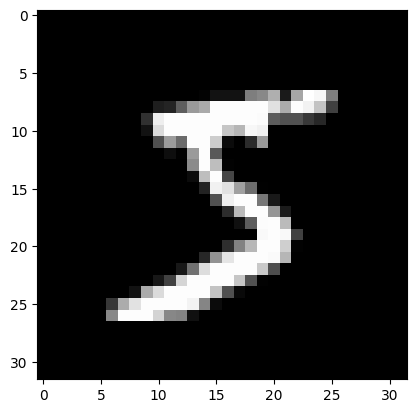

In [10]:
plt.imshow(x_train[0], cmap="gray")

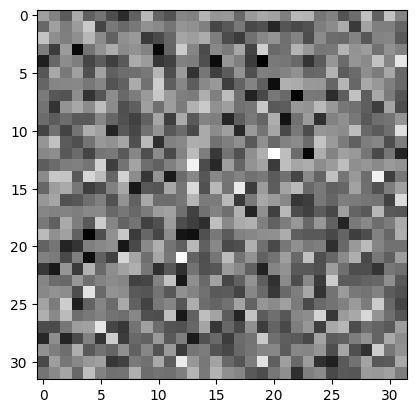

In [11]:
plt.imshow(add_noise(x_train[0], 1), cmap="gray")

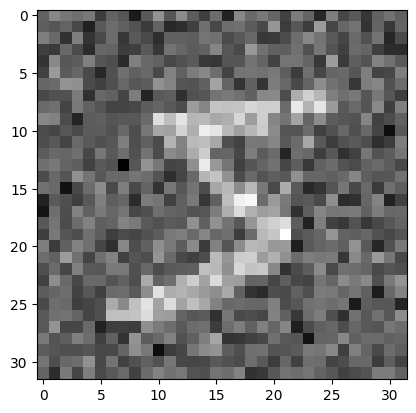

In [12]:
plt.imshow(add_noise(x_train[0], 0.2), cmap="gray")

**Nota** La rete impara a fare denoising e quindi a generare immagini da rumore

## Costruzione Dataset
+ Target: img originale
+ Feature: img con rumore

In [13]:
from tensorflow.data import Dataset # per avere dei batch dal data_generator

In [14]:
x_train.shape

(60000, 32, 32)

In [15]:
# funzione per trasformare le imgs del mnist in imgs con noise, ritorna feature e target
def data_generator(x_train):
    for i in range(x_train.shape[0]): # per ogni immagine
        img = x_train[i]
        noise = tf.random.normal(shape=img.shape)
        noise_amount = tf.random.uniform(shape=[], minval=0, maxval=1) # shape = shape del tensore in output (non ha shape perché è il coefficiente scalare del rumore!)
        noise_img = noise_amount*noise + (1-noise_amount)*img

        yield tf.expand_dims(noise_img, axis = -1), tf.expand_dims(img, axis = -1) # aggiunge una dimensione di len 1: il canale

In [16]:
# per capire shape = []
noise_amount = tf.random.uniform(shape=[], minval=0, maxval=1)
noise_amount.shape # non ha shape perché è il coefficiente scalare del rumore!

TensorShape([])

In [ ]:
next(iter(data_generator(x_train)))[0].shape
#next(data_generator(x_train))[0].shape
# Nota: data_generator restituisce già un oggetto generatore che è iterabile

In [16]:
dataset = Dataset.from_generator(
    generator=lambda: data_generator(x_train),
    output_signature=(
        tf.TensorSpec(shape=[32,32, 1]), # come è fatto il valore che ritorna il generatore (h x w x c)
        tf.TensorSpec(shape=[32,32, 1])
    ) # 2 TensorSpec perché data_generator() ritorna due valori: feature e target
)

In [17]:
dataset = dataset.shuffle(buffer_size=1_000).batch(128)

## Training

In [18]:
from keras.optimizers import Adam
from keras.losses import MeanSquaredError # è un compito di regressione, prevedere il valore di ogni pixel (in grayscale)
from keras.metrics import MeanAbsoluteError

In [19]:
fcnn.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=MeanAbsoluteError()
)

In [20]:
fcnn.fit(x = dataset, initial_epoch=0, epochs = 1)

2023-09-28 18:08:54.210836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-28 18:08:54.212144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


      1/Unknown - 77s 77s/step - loss: 0.0621 - mean_absolute_error: 0.0802

2023-09-28 18:10:11.160996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-09-28 18:10:11.185208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1/1 [==============================] - 77s 77s/step - loss: 0.0621 - mean_absolute_error: 0.0802


---

In [ ]:
vedi file prof. x parte sotto

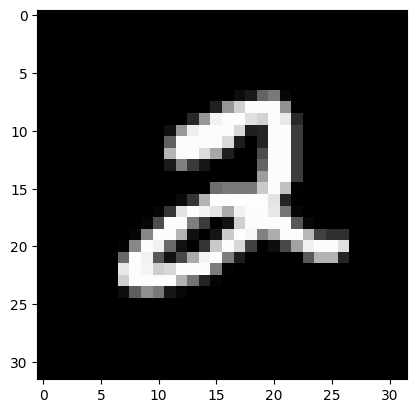

In [21]:
plt.imshow(x_train[5], cmap="gray")

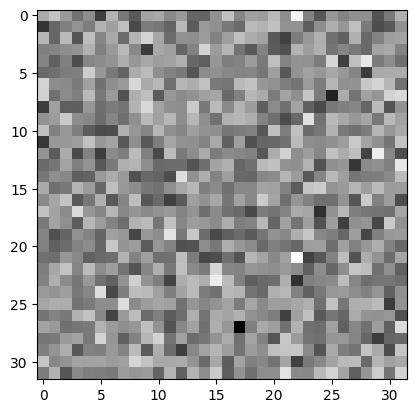

In [22]:
plt.imshow(add_noise(x_train[5], 1.), cmap="gray")

In [23]:
pred = fcnn(add_noise(x_train[4], 1.)[None, :, :, None])

In [24]:
pred.shape

TensorShape([1, 32, 32, 1])

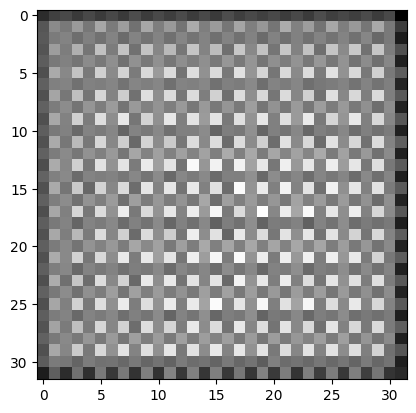

In [25]:
plt.imshow(pred.numpy().reshape(32, 32), cmap="gray")

In [26]:
#
nsteps = 20
x = tf.random.normal([1, 32, 32, 1])

for i in range(nsteps):
    y = fcnn(x)
    retention_factor = 1 / (nsteps-i)
    x = y*retention_factor + tf.random.normal([1, 32, 32, 1])*(1-retention_factor)

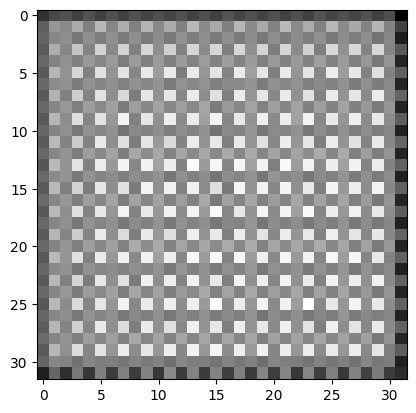

In [27]:
plt.imshow(np.clip(x.numpy(),0,1).reshape([32,32]), cmap="gray")